In [9]:
%run Prep_CART_data.ipynb

Ratio of All Patients with Low Engraftment: 0.542
Ratio of Cohort 1 and 3 Patients with Low Engraftment: 0.526


In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from mpl_toolkits import mplot3d

In [53]:
def tune_svm(final_data):
    svm_model = svm.SVC()
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
    grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, scoring='accuracy')
    grid_result = grid.fit(final_data.iloc[:,:-1], final_data.iloc[:,-1])
    
    #print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    #means = grid_result.cv_results_['mean_test_score']
    #stds = grid_result.cv_results_['std_test_score']
    #params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print("%f (%f) with: %r" % (mean, stdev, param))
    
    return grid_result.cv_results_, grid_result.best_params_

In [47]:
ww, all_cohort_bestParams = tune_svm(FinalData_all_cohort)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

In [54]:
ss, two_cohort_bestParams = tune_svm(FinalData_two_cohort)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

In [48]:
print(ww.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [49]:
def GridSearch_figs(grid_dict):
    param_gamma = grid_dict['param_kernel']
    param_C = grid_dict['param_C']
    scores = grid_dict['mean_test_score']
    
    df = pd.DataFrame()
    for C in param_C:
        temp_gamma = param_gamma[param_C == C]
        df['gamma'] = temp_gamma.astype(str)
        temp_scores = scores[param_C == C]
        df[str(C)] = temp_scores
    fig = px.imshow(df.iloc[:,1:], y = df['gamma'], color_continuous_scale = px.colors.sequential.RdBu_r)
    fig.show()
    
    lines_df = pd.DataFrame.from_dict(grid_dict)
    lines_df['C Parameter'] = lines_df['param_C'].astype(str)
    fig = px.line_3d(lines_df, x = 'C Parameter', y = 'param_gamma', z = 'mean_test_score',
                    color = lines_df['param_kernel'],labels = {'mean_test_score' : 'Mean Test AUC',
                                                              'param_gamma' : 'Gamma Parameter',
                                                              'param_kernel' : 'Kernel Parameter'})
    fig.show()

GridSearch_figs(ww)

True Labels: [0 0 1 0 0 1 1 1]
Engraftment Predictions:  [0 0 1 0 1 0 0 1]
Accuracy for All Patients: 0.62
AUC for All Patients: 0.81


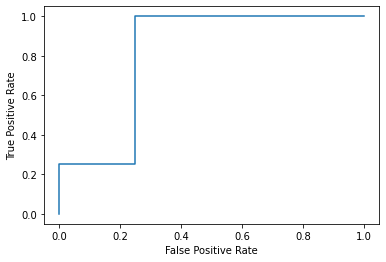

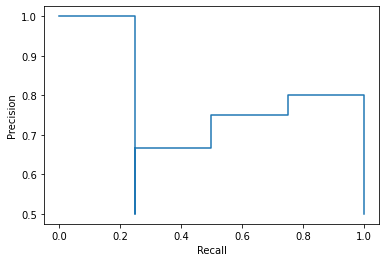

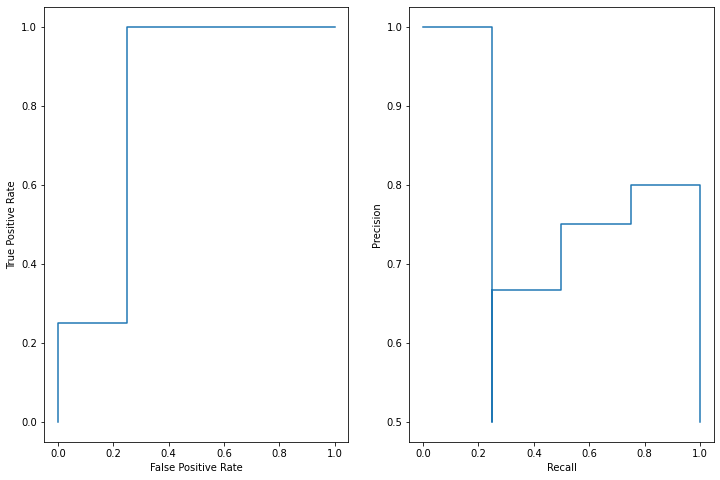

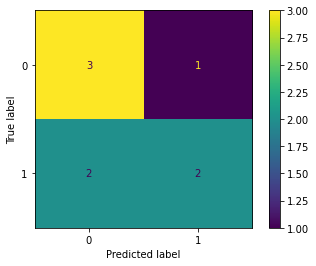

In [45]:
def train_and_test_svm(final_data, bestParams, dataType):
    #print(f'Best Parameters for {dataType}:', bestParams)
    
    X = np.array(final_data['PCA_0']).reshape(-1,1)
    y = np.array(final_data.iloc[:,-1])
    
    #X = final_data.iloc[:,:-1].to_numpy()
    #y = np.array(final_data.iloc[:,-1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state=42)
    
    svm_model = svm.SVC(kernel= bestParams['kernel'], C=bestParams['C'], gamma = bestParams['gamma'],
                        random_state=42)
    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)
    y_score = svm_model.decision_function(X_test)
    print('True Labels:', y_test)
    print('Engraftment Predictions: ', y_pred)
    
    accuracy = np.count_nonzero(y_pred == y_test)/len(y_test)
    print(f'Accuracy for {dataType}: %0.2f' %accuracy)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=svm_model.classes_[1])
    auc = metrics.auc(fpr, tpr)
    print(f'AUC for {dataType}: %0.2f' %auc)

    #ROC curve and precision-recall curve
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=svm_model.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
train_and_test_svm(FinalData_all_cohort, all_cohort_bestParams, 'All Patients')